# Проверка гипотез по увеличению выручки в интернет-магазине. <br>Оценка результатов A/B теста

## Описание проекта
Отдел аналитики крупного интеренет-магазина совместно с отделом маркетинга подготовили список гипотез для увеличения выручки. На первом этапе стоит задача приоритезации гипотез, после чего предстоит результатов проведенного A/B-теста.

[Часть 1. Приоритизация гипотез](#section_1)
- [Подготовка данных для приотеризации гипотез](#section_2)
- [Применение фреймворка ICE](#section_3)
- [Применение фреймворка RICE](#section_4)
- [Сравнение применения  ICE и RICE](#section_5)
- [Вывод](#section_6)

[Часть 2. Анализ A/B-теста](#section_7)
- [Подготовка данных для анализа результатов A/B тестов](#section_8)
- [Анализ кумулятивной выручки по группам](#section_9)
- [Анализ среднего чека по группам](#section_10)
- [Относительное различие среднего чека группа B / группа А](#section_11)
- [Кумулятивная конверсия](#section_12)
- [Относительное изменения кумулятивной конверсии группы B к группе A](#section_13)
- [Анализ количества заказов](#section_14)
- [Анализ стоимости заказов](#section_15)
- [Статистическая значимость различий конверсии между группами по «сырым» данным](#section_16)
- [Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#section_17)
- [Cтатистическая значимость различий в конверсии между группами по «очищенным» данным](#section_18)
- [Cтатистическая значимость различий среднего чека между группами по «очищенным» данным](#section_19)
- [Выводы по A/B тесту](#section_20)

## Часть 1. Приоритизация гипотез <a id='section_1'></a>

### Подготовка данных для приотеризации гипотез <a id='section_2'></a>

In [46]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns 
%matplotlib inline

Прочитаем файл с гипотезами и сохраним данные о визитах и закахаз в переменной `hypothesis_df`.

In [47]:
hypothesis_df = pd.read_csv('/datasets/hypothesis.csv')
pd.set_option('display.max_colwidth', -1)

Создадим функцию для получения базовой информации по датафрейму

In [48]:
def df_info(df):
    '''Функция возвращает 
    базовую информацию по датафрейму'''
    display(df.info())
    display(df.head(10))
    display(df.describe())

In [49]:
df_info(hypothesis_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Первый взгляд на датафрейм с гипотезами:
- пропуски отсутствуют
- тип данных - корректный
- числовые данные находятся в пределах крайних значений шкалы оценки параметров гипотез. По ним можно сказать, что как минимум у половины гипотез охват аудитории ниже среднего значения. Также, миниум половина гипотез характеризуется силой влияния ниже среднего значения параметра. Зато, уверенность в параметрах большинства гипотез можно охарактеризовать, как высокую.

Единственная корректировка, которую хотелось бы сразу внести - это приведение заглавных букв в названиях колонок к нижнему регистру

In [50]:
hypothesis_df.columns = hypothesis_df.columns.str.lower()

Для удобства пронумеруем гипотезы в отдельной колонке

In [51]:
hypothesis_df['hypothesis_number'] = (np.arange(len(hypothesis_df['hypothesis']))+1).astype('str')
hypothesis_df

,hypothesis,reach,impact,confidence,efforts,hypothesis_number
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,1
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,5
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,6
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,7
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,8
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,9


### Применение фреймворка ICE <a id='section_3'></a>

Применим фреймворк ICE для приоритизации гипотез и изучим получейнный результат.

In [52]:
hypothesis_df['ICE'] = ((hypothesis_df['impact'] * hypothesis_df['confidence']) 
                        / hypothesis_df['efforts']).round(2)

hypothesis_df[['hypothesis','hypothesis_number', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,hypothesis_number,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",9,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",1,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",8,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",7,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",6,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",4,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",5,1.00


Гипотеза №9 является наиболее перспектиной. За ней следуют гипотезы 1, 8. Гипотезы 7 и 3 также стоит держать в фокусе. Посмотрим на распределение приоритетов гипотез с применением фреймворка RICE.

### Применение фреймворка RICE <a id='section_4'></a>

In [53]:
hypothesis_df['RICE'] = ((hypothesis_df['impact'] * hypothesis_df['impact'] * hypothesis_df['confidence']) 
                         / hypothesis_df['efforts']).round(2)
hypothesis_df = hypothesis_df.sort_values(by='RICE', ascending=False)
hypothesis_df[['hypothesis','hypothesis_number', 'ICE', 'RICE']]

,hypothesis,hypothesis_number,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",9,16.20,145.80
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",1,13.33,133.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",8,11.20,78.40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",7,8.00,24.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",3,7.00,21.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,2.00,10.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",4,1.12,3.38
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",6,1.33,2.67
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",5,1.00,1.00


### Сравнение применения  ICE и RICE <a id='section_5'></a>

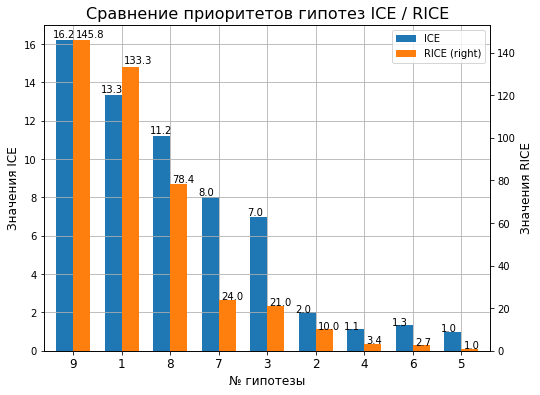

In [54]:
ax = hypothesis_df[['ICE', 'RICE']].\
plot(kind='bar', width=0.7, grid=True, figsize=(8,6), secondary_y=['RICE'])

ax.set_title('Сравнение приоритетов гипотез ICE / RICE', fontsize=16)
ax.set_xlabel('№ гипотезы', fontsize=12)
ax.set_ylabel('Значения ICE', fontsize=12)
ax.right_ax.set_ylabel('Значения RICE', fontsize=12)
ax.set_xticklabels(hypothesis_df['hypothesis_number'], fontsize=12, rotation=0)


for p in ax.patches:
    ax.annotate(round(p.get_height(), 1).astype('str'), (p.get_x() -.07, p.get_height() * 1.01))
    
for p in ax.right_ax.patches:
    ax.right_ax.annotate(round(p.get_height(), 1).astype('str'), (p.get_x()+.05, p.get_height() * 1.01))

plt.show()

### Вывод <a id='section_6'></a>

По сравнению с фреймворком  ICE порядок распределения главных гипотез RICE не изменился, но среди всех по приоритету стали явно выдяляться две гипотезы:
- наиболее приоритетной по-прежнему является **гипотеза 9** *'Запустить акцию, дающую скидку на товар в день рождения'*. Даже несмотря на минимальный охват, параметры силы влияния и уверенности в оценках других параметров делают эту гипотезу наиболее приороиетной для тестирования
- Второй по приоритету гипотезой, которая также явно выделяется яляется **гипотеза 1** *'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей'*. Охват у нее также небольшой, но масимальная сила влияния в сочетании с умеренными затратами и высоким уровнем доверия к параметрам также позволяют вынести эту гипотезу в список приоритетных для проверки.
- **Гипотеза 8** *'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'* после применения фреймфорка RICE сохранила третий приоритет, но заметно увеличив отрыв по этому показателю от других гипотез.

В целом, подсчет **RICE** позволил нам явно выделить три гипотезы для дальнешей проверки, чего нельзя было обнозначно сказать, после подсчет **ICE**.

## Часть 2. Анализ A/B-теста <a id='section_7'></a>

### Подготовка данных для анализа результатов A/B тестов <a id='section_8'></a>

Сохраним данные о визитах и закахаз в переменных `visitors_df` и `orders_df` соответственно.

In [55]:
orders_df = pd.read_csv('/datasets/orders.csv', dtype={'visitorId':'object', 'transactionId':'object'})
visitors_df = pd.read_csv('/datasets/visitors.csv')

Оценим полученные результаты после проведенных A/B тестов в датафрейме `visitors_df`.


In [56]:
df_info(visitors_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


**Что удалось обнаружить в данных о посещениях:**
- пропуски отсутствуют
- есть проблема с форматом дат
- данные с визитами собраны за два меясца, количество посетителей выглядит правдоподобным с умеренным стандартным отклонением.

Приведем даты в данных о посещениях к соответсвующему формату

In [57]:
visitors_df['date'] = visitors_df['date'].\
                        map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Оценим полученные результаты после проведенных A/B тестов в датафрейме `orders_df`.

In [58]:
orders_df.info()
display(orders_df.head())
orders_df['revenue'].describe().apply(lambda x: format(x, 'f'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null object
visitorId        1197 non-null object
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(1), object(4)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


count    1197.000000   
mean     8348.005848   
std      39191.131774  
min      50.000000     
25%      1220.000000   
50%      2978.000000   
75%      8290.000000   
max      1294500.000000
Name: revenue, dtype: object

**Что удалось обнаружить в данных с заказами:**
- пропуски отсутствуют
- есть проблема с форматом дат
- очевидно есть выбросы в данных с выручкой заказа (учтем их при дальнейшей работе с данными)

Приведем даты в данных о заказах к соответсвующему формату

In [59]:
orders_df['date'] = orders_df['date'].\
                        map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим уникальность пользователей для каждой из групп. Не попадают ли один и теже пользователи в группу A и группу B.

In [60]:
#создадим отдельный датафрейм со списком НЕуникальных пользователей
wrong_visitors = orders_df.groupby(['visitorId']).\
                    agg({'group':'nunique', 'transactionId':'count'}).\
                    query('group > 1').reset_index()

display(wrong_visitors.sort_values(by='transactionId', ascending=False).head())
print('Количество неуникальных пользователей:', wrong_visitors.shape[0])

,visitorId,group,transactionId
18,2458001652,2,11
50,4256040402,2,11
17,2378935119,2,9
13,2038680547,2,8
12,199603092,2,5


Количество неуникальных пользователей: 58


Похоже такие пользователи есть - их 58. Возможно, это ошибка сплитования аудитории, либо тестовые пользователи. Так или иначе, для A/B тестирования такая ситуация недопустима. Поэтому удалим таких толькователей, предварительно сохранив их в отдельный датафрейм `wrong_visitors`. Более того, среди них есть предположительные выбросы по количеству заказов на одного пользователя: 8, 9, 11. Вернемся к этому вопросу немного позднее на этапе оценки показателя количества заказов на  одного пользователя.

Следует учесть, что данные по неуникальным пользователям уже сагрегированы в датафрейме `visitors_df`. Следовательно, выделить пользовательские сессии неуникальных пользователей не представляется возможным. Что бы минимизировать степень влияния таких пользователей на конечный результат, уменьшим число визитов для каждого дня на число неуникальных пользователей для каждого конкретного дня. Для этого создадим предварительно датафрейм с количеством визитов по дням `wrong_visitors_dates`, которые необходимо вычесть из `visitors_df['visitors']`.

In [61]:
wrong_visitors_dates = orders_df.query('visitorId in @wrong_visitors.visitorId').\
                                    groupby('date')['visitorId'].count().reset_index()
wrong_visitors_dates.columns = ['date', 'wrong_visits']
wrong_visitors_dates.head()

,date,wrong_visits
0,2019-08-01,5
1,2019-08-02,2
2,2019-08-03,2
3,2019-08-04,8
4,2019-08-05,5


Теперь очистим датафрейм с заказами `orders_df` от записей пользоваталей, присутствующих в обоих группах А и В.

In [17]:
orders_df = orders_df[~orders_df['visitorId'].isin(wrong_visitors['visitorId'])]

Присоединим к датафрейму с визитами по столбцу `date` количество неуникальных пользователей. Т.к. точное количество визитов нам не известно, делаем это из расчета, что `заказ/заказы каждого пользователя в день = 1 гарантированный визит в этот день`. Руководствуясь этим, уменьшим число визитов для каждого дня на число неуникальных пользователей для каждого конкретного дня. После этого удалим вспомогательный столбец с некорректными визитами `wrong_visits`

In [18]:
visitors_df = visitors_df.merge(wrong_visitors_dates, on='date', how='left').fillna(0)
visitors_df['visitors'] = visitors_df['visitors'] - visitors_df['wrong_visits']
visitors_df = visitors_df.drop(['wrong_visits'], axis=1)
visitors_df.head()

,date,group,visitors
0,2019-08-01,A,714
1,2019-08-02,A,617
2,2019-08-03,A,505
3,2019-08-04,A,709
4,2019-08-05,A,751


Продолжим подготовку данных для дальнейшего анализа A/B тестов. Создадим массив уникальных пар значений дат и групп теста

In [19]:
datesGroups = orders_df[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Соберём агрегированные кумулятивные по дням данные о заказах, количестве покупателей и доходах от заказов

In [20]:
ordersAggregated = datesGroups.\
                    apply(lambda x: orders_df[np.logical_and(orders_df['date'] <= x['date'], orders_df['group'] == x['group'])].\
                    agg({'date' : 'max', 
                         'group' : 'max', 
                         'transactionId' : 'nunique', 
                         'visitorId' : 'nunique', 
                         'revenue' : 'sum'}), axis=1).\
                    sort_values(by=['date', 'group'])
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


По аналогии с заказами, создадим датафрейм с куммулятивными данными по дням о посетителях интернет-магазина для дальнейшего анализа `посетитель != покупатель`

In [21]:
visitorsAggregated = datesGroups.\
                        apply(lambda x: visitors_df[np.logical_and(visitors_df['date'] <= x['date'], visitors_df['group'] == x['group'])].\
                              agg({'date' : 'max', 
                                   'group' : 'max', 
                                   'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,714
66,2019-08-01,B,708
175,2019-08-02,A,1331
173,2019-08-02,B,1287
291,2019-08-03,A,1836


Объеденим сагрегированные по дням данные о заказах и посетителях в одной таблице `cumulativeData`

In [22]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,714
1,2019-08-01,B,17,17,59758,708
2,2019-08-02,A,42,36,234381,1331
3,2019-08-02,B,40,39,221801,1287
4,2019-08-03,A,66,60,346854,1836


### Анализ кумулятивной выручки по группам <a id='section_9'></a>

Создадим датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням в группах А и B

In [23]:
cumulativeReveuneA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeReveuneB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

Построим графики кумулятивной выручки по дням

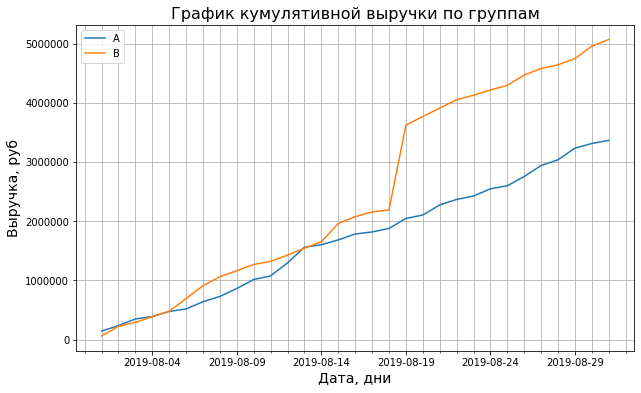

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(cumulativeReveuneA['date'], cumulativeReveuneA['revenue'], label='A')
ax.plot(cumulativeReveuneB['date'], cumulativeReveuneB['revenue'], label='B')

ax.set_title('График кумулятивной выручки по группам', fontsize=16)
ax.set_xlabel('Дата, дни', fontsize=14)
ax.set_ylabel('Выручка, руб', fontsize=14)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which='both')

plt.legend()
plt.show()

До 19 августа выручка увеличивалась равномерно с небольшим превосходством пользователей группы B, но в указанную дату в группе B отмечается резкий скачок кумялятивной выручки более чем на 1 млн руб. Это явный сигнал появления в выборке очень дорогого/дорогих заказов. В дальнейшем проанализируем выбросы более детально

### Анализ среднего чека по группам <a id='section_10'></a>

Построим графики среднего чека по группам, разделим кумулятивную выручку на кумулятивное число заказов.

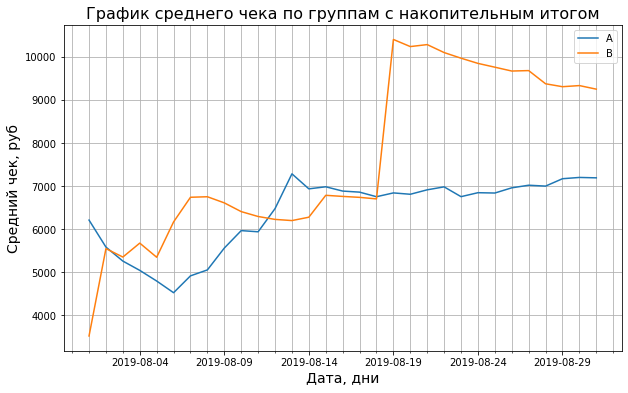

In [25]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(cumulativeReveuneA['date'], 
        cumulativeReveuneA['revenue']/cumulativeReveuneA['orders'], label='A')
ax.plot(cumulativeReveuneB['date'], 
        cumulativeReveuneB['revenue']/cumulativeReveuneB['orders'], label='B')

ax.set_title('График среднего чека по группам с накопительным итогом', fontsize=16)
ax.set_xlabel('Дата, дни', fontsize=14)
ax.set_ylabel('Средний чек, руб', fontsize=14)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which='both')

plt.legend()
plt.show()

График среднего чека подтверждает наличие в данных группы B крупных заказов в районе 19 августа и вносит существенные искажения. Также, можно предположить, что в начале теста в группу B попадали более крупные заказы. К 15 августа показатели кумулятивного среденго чека двух групп выроснялись, после чего в группе B предположительно произошел крупный заказ на сумму 1,2 млн руб, на который мы обращали внимание еще на этапе ознакомления с данныыми, после чего, средний чек по группе B начал снижаться, в то время как в группе A он стабилизировался.

### Относительное различие среднего чека группа B / группа А <a id='section_11'></a>

Посмотрим на график относительного различия для среднего чека группы B к группе A. Для этого предварительно объединим датафреймы с данными двух групп в один `mergedCumulativeRevenue`

In [26]:
mergedCumulativeRevenue = cumulativeReveuneA.\
                            merge(cumulativeReveuneB, on='date', suffixes=['A', 'B'])
mergedCumulativeRevenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


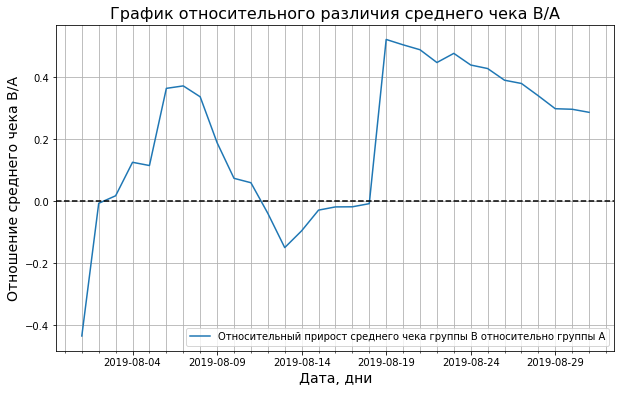

In [27]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(mergedCumulativeRevenue['date'],
        (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
        (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1,
         label="Относительный прирост среднего чека группы B относительно группы A")

ax.set_title('График относительного различия среднего чека B/A', fontsize=16)
ax.set_xlabel('Дата, дни', fontsize=14)
ax.set_ylabel('Отношение среднего чека B/A', fontsize=14)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which='both')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()

Раличия среднего чека между группами очевидны. Как минимум в трех местах динамика среднего чека группы B по отношению к группе A меняет направление. Очевидно, имеем дело с выбросами. Очень вероятно, что они имеются в обоих группах. Не будем оставлять это без внимания.

### Кумулятивная конверсия <a id='section_12'></a>

Аналогичным образом проанализируем кумулятивную конверсию по группам

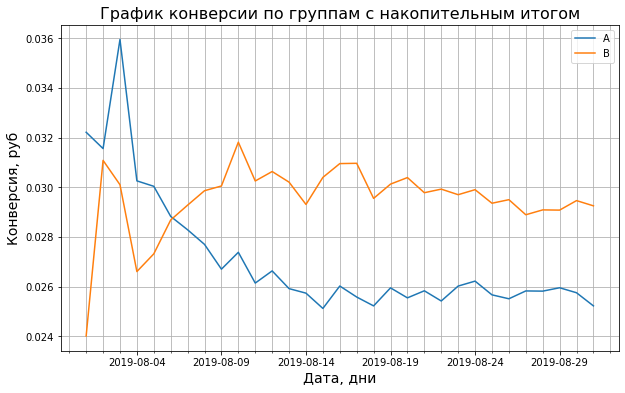

In [28]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
ax.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

ax.set_title('График конверсии по группам с накопительным итогом', fontsize=16)
ax.set_xlabel('Дата, дни', fontsize=14)
ax.set_ylabel('Конверсия, руб', fontsize=14)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which='both')

plt.legend()
plt.show()

Первая треть периода проведения теста характеризовалась значительными колебаниями в обоих группах, после чего показатель кумулятивной конверсии стабилизировался. Начиная с 6 августа показатель кумулятивной конверсии пользователей группы B превысил аналогичный показатель по группе A. Ближе к концу проведения теста колебания в обоих группах снижаются, а конверсия в гурппе B заметно выше группы А на протяжении почти всего теста. Оценим  относительное изменения кумулятивной конверсии группы B к группе A.

### Относительное изменения кумулятивной конверсии группы B к группе A <a id='section_13'></a>

Объединим датафреймы с данными о накопительной конверсии двух групп в один `mergedCumulativeConversion`

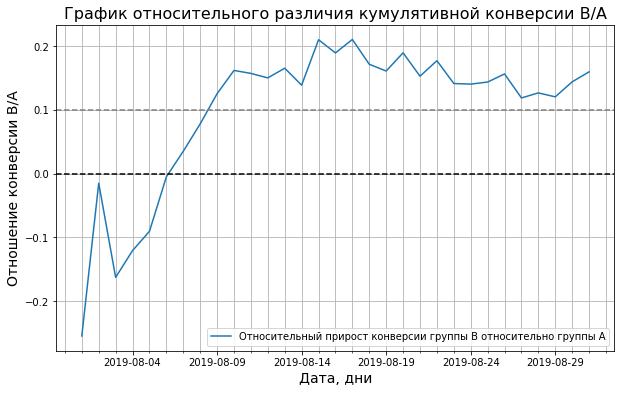

In [29]:
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].\
                             merge(cumulativeDataB[['date', 'conversion']], 
                             on='date', suffixes=['A', 'B'])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(mergedCumulativeConversions['date'], 
        (mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1),
        label="Относительный прирост конверсии группы B относительно группы A")

ax.set_title('График относительного различия кумулятивной конверсии B/A', fontsize=16)
ax.set_xlabel('Дата, дни', fontsize=14)
ax.set_ylabel('Отношение конверсии B/A', fontsize=14)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which='both')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.legend()
plt.show()


В начале теста группа В проигрывала группе А. Возможно, это обусловлено небольшой выборкой. Однако, по мере накопления пользовательских действий, группа B спустя неделю тестрирования опередила группу A по показателю кумулятивной конверсии и стабильно сохраняла превосходство над группой А более чем на 10%. Для полноты картины необходимо исследовать аномалии, которые точно имели место быть, и которые, возможно внесли коррективы в результаты анализа "сырых данных".

### Анализ количества заказов <a id='section_14'></a>

Оценим количество заказов по пользователям и оценим результат

In [30]:
ordersByUsers = orders_df.drop(['date', 'revenue', 'group'], axis=1).\
                groupby('visitorId', as_index=False).\
                agg({'transactionId':'nunique'}).\
                sort_values(by='transactionId', ascending=False)

ordersByUsers.columns = ['visitorId', 'orders']

ordersByUsers.head()

,visitorId,orders
507,2988190573,3
376,249864742,3
442,2742574263,3
274,2108163459,3
749,3967698036,3


У нас отсутствуют пользователи, совершившие более 3 заказов. Однако, как мы заметили ранее такие пользователи были. Они были не уникальными и фигурировали как в группе А, так и в группе В. На этапе предобработке мы очистили датайрем от таких данных, таким образом, избавившись от аномальных пользователей одновременно с удалением ошибочных/неуникальых пользователей. Напоним, что мы избавились от пользователей в числе которых были юзеры с 8, 9, 11 заказами. Построим точечную диаграмму числа заказов на одного пользователя, убедившись в этом.

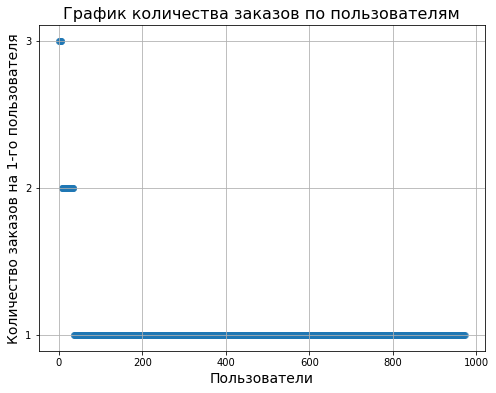

In [31]:
x_values = pd.Series(range(0,len(ordersByUsers)))

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x_values, ordersByUsers['orders'], alpha=.5)

ax.set_title('График количества заказов по пользователям', fontsize=16)
ax.set_xlabel('Пользователи', fontsize=14)
ax.set_ylabel('Количество заказов на 1-го пользователя', fontsize=14)

ax.yaxis.set_major_locator(MultipleLocator(1))
ax.grid(which='both')

plt.show()

Видим, что все значения лежат в пределах 3 заказов на пользователя, что является вполне адекватной цифрой. Это ожидаемо, с учетом того, что ранее мы уже очистили данные от пользователей с аномально большим количеством заказов. Посчитаем выборочыне перцентили количества заказов на одного пользователя:

In [32]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Не более 1% пользователей оформляли заказ более 2 раз. Однако, вряд ли количество заказов 2 и более можно считать аномалиями. Посмотрим, были ли удаленные бользователи аномальными с точки зрения количества заказов. Для этого посчитаем  выборочные перцентили для всех пользователей, которые в рабочем датафрейме уже удалены.

In [33]:
orders_all_users = pd.read_csv('/datasets/orders.csv', dtype={'visitorId':'object', 'transactionId':'object'}).\
                    drop(['date', 'revenue', 'group'], axis=1).\
                    groupby('visitorId', as_index=False).\
                    agg({'transactionId':'nunique'}).\
                    sort_values(by='transactionId', ascending=False)

orders_all_users.columns = ['visitorId', 'orders']

print(np.percentile(orders_all_users['orders'], [95, 99]))

[2. 4.]


Наше предположение подтвердилось. Удаленные пользователи являлись выбросами, а пользователи с 3 заказами - абсолютно нормальное явление. Не более 1%  пользователей оформляли заказ более 4 раз.  Можем работать с ними дальше. Таком образом, на основании проанализированных данных установим границу для определения аномальных пользователей - **более 3 заказов**.

### Анализ стоимости заказов <a id='section_15'></a>

Ранее, на этапе первичного ознакомления с данными мы уже заметили анаомально высокие заказы. На данном этапе попытаемся понять в каких пределах стоимости лежит основная часть заказов. Для начала попробуем определить визуально с помощью точечной гистограммы.

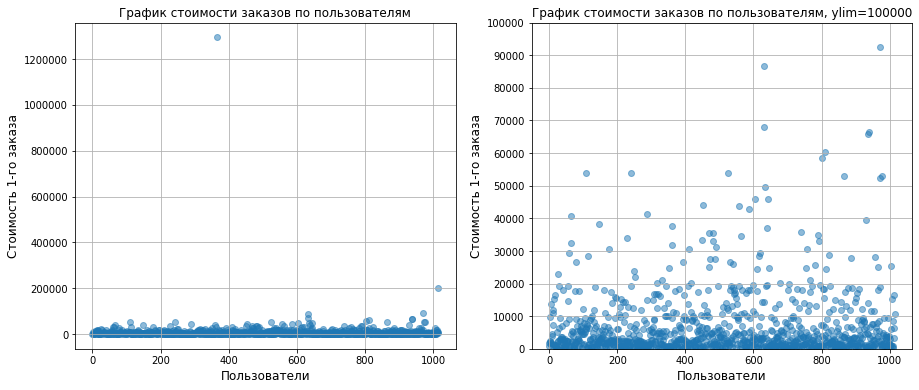

In [34]:
x_values = pd.Series(range(0, len(orders_df['revenue'])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.scatter(x_values, orders_df['revenue'], alpha=.5)
ax1.set_title('График стоимости заказов по пользователям', fontsize=12)
ax1.set_xlabel('Пользователи', fontsize=12)
ax1.set_ylabel('Стоимость 1-го заказа', fontsize=12)
#ax1.yaxis.set_major_locator(MultipleLocator(20000))
ax1.grid(which='both')

ax2.scatter(x_values, orders_df['revenue'], alpha=.5)
ax2.set_title('График стоимости заказов по пользователям, ylim=100000', fontsize=12)
ax2.set_xlabel('Пользователи', fontsize=12)
ax2.set_ylabel('Стоимость 1-го заказа', fontsize=12)
ax2.set_ylim(0, 100000)
ax2.yaxis.set_major_locator(MultipleLocator(10000))
ax2.grid(which='both')

plt.show()

Точеынй график слева демонстрирует как минимум два очевидных выброса, о которых мы догадывались ранее, но он не является информативным по части остальных данных. Поэтому применим масштабирование и получим более информативный график касательно данных о стоимости заказов до 100000 руб. Теперь мы видим, что без учета очевидных аномалий, основаня часть заказов лежит в пределах 20000 руб. Более точную границу аномальных заказов определим с помощью перцентилей. Обнаруженные аномалии скорее всего сильно повлияли на показатели среднего чека и выручки.

In [35]:
print(np.percentile(orders_df['revenue'], [95, 99]))

[26785. 53904.]


Видим, что не более 5% заказов дороже 26 785 руб. и не более 1% дороже 53 904 руб. **Определим 26 785 руб как нижнюю границу стоимости аномально большого заказа**. Отсеим аномальных пользователей по ней.

### Статистическая значимость различий конверсии между группами по «сырым» данным <a id='section_16'></a>

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Для начала подготовим данные соответствующим образом.

In [36]:
visitorsADaily = visitors_df[visitors_df['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors_df[visitors_df['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsACummulative = visitorsADaily.\
                        apply(lambda x:
                           visitorsADaily[visitorsADaily['date'] <= x['date']].\
                              agg({'date' : 'max',
                                   'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBCummulative = visitorsBDaily.\
                        apply(lambda x:
                           visitorsBDaily[visitorsBDaily['date'] <= x['date']].\
                              agg({'date' : 'max',
                                   'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders_df[orders_df['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']].\
                   groupby('date', as_index=False).\
                    agg({'transactionId' : 'nunique',
                         'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = orders_df[orders_df['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']].\
                   groupby('date', as_index=False).\
                    agg({'transactionId' : 'nunique',
                         'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersACumulative = ordersADaily.\
                        apply(lambda x:
                             ordersADaily[ordersADaily['date'] <= x['date']].\
                                 agg({'date' : 'max',
                                      'ordersPerDateA' : 'sum',
                                      'revenuePerDateA' : 'sum'}), axis=1).\
                                 sort_values(by='date')
ordersACumulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBCumulative = ordersBDaily.\
                        apply(lambda x:
                             ordersBDaily[ordersBDaily['date'] <= x['date']].\
                                 agg({'date' : 'max',
                                      'ordersPerDateB' : 'sum',
                                      'revenuePerDateB' : 'sum'}), axis=1).\
                                 sort_values(by='date')
ordersBCumulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

all_data = ordersADaily.merge(ordersBDaily, on='date').\
            merge(ordersACumulative, on='date').\
            merge(ordersBCumulative, on='date').\
            merge(visitorsADaily, on='date').\
            merge(visitorsBDaily, on='date').\
            merge(visitorsACummulative, on='date').\
            merge(visitorsBCummulative, on='date')

all_data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,714,708,714,708
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,617,579,1331,1287
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,505,507,1836,1794
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,709,762,2545,2556
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,751,702,3296,3258


Создадим датафреймы с пользователями, которые заказывали хотя бы 1 раз, укажем число совершённых заказов: `ordersByUsersA` и `ordersByUsersB`

In [37]:
ordersByUsersA = orders_df[orders_df['group']=='A'].\
                    groupby('visitorId', as_index=False).\
                        agg({'transactionId':'nunique'})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders_df[orders_df['group']=='B'].\
                    groupby('visitorId', as_index=False).\
                        agg({'transactionId':'nunique'})
ordersByUsersB.columns = ['userId', 'orders']

Объеденим созданные в предыдущем шаге датафреймы с пользователями, которые не совершали заказы и сохраним их в переменных `sampleA` и `sampleB`

In [38]:
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, 
            index=np.arange(all_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), 
            name='orders')])

sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, 
            index=np.arange(all_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), 
            name='orders')])

Т.к. в данных имеются выбросы, проверим наши 'сырые' данные на наличие статистически значимых различий в конверсии с помощью критерия Манна-Уитни. Напомним, что `sampleA` и `sampleB` содержат данные по заказам всех пользоватей (в т.ч. и пользователи с нулевым кол-м заказом). Таким, образом среднее значение по количеству заказов (с учетом нулей) и будет является средним показателем конверсии. Сопоставим эти параметры для групп B/A и и выясним статистическую значимость. Значение  `alpha = 0.05` (здесь и далее)

In [39]:
print('p-value = {:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Отношение конверсии B/A = {:.1%}'.format(sampleB.mean() / sampleA.mean() - 1))

p-value = 0.006
Отношение конверсии B/A = 16.0%


Анализ сырых данных по конверсии показал, что значимые в конверсии групп A и B имеются. А значение p-value указывает на значимость этих различий. Можем сделать предварительный вывод, что изменения положительно повлияли на показатель пользовательсокой конверсии в покупку. Однако, не забываем, что мы работаем с "сырыми" данными. Впереди анализ "очищенных" данных и работа с другими показателями. Посмотрим, что они покажут

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным <a id='section_17'></a>

Найдем относительные различия в среднем чеке между группами

In [40]:
print('p-value = {:.3f}'.format(stats.mannwhitneyu(orders_df[orders_df['group']=='A']['revenue'], 
                                                   orders_df[orders_df['group']=='B']['revenue'])[1]))

print('Отношение среднего чека B/A = {:.1%}'.format(orders_df[orders_df['group']=='B']['revenue'].mean()/
                                                     orders_df[orders_df['group']=='A']['revenue'].mean()-1))

p-value = 0.415
Отношение среднего чека B/A = 28.7%


P-value заметно выше 0.05. Следовательно, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B немного ниже среднего чека группы A. Напомним, что у нас имеются аномально большие заказы. Для достоверной картины, нам необходимо очистить данные от выбросов и проанализировать очищенные данные.

### Cтатистическая значимость различий в конверсии между группами по «очищенным» данным <a id='section_18'></a>

Пользователи с аномально большим количеством заказом уже очистились эстественным образом на этапе удаления неуникальных юзеров, пристутствующих одновременно в двух группах. Таким образом, нам осталось сделать срез данных, в котором мы **очистим данные от пользователей с суммой заказа более 26785 руб.** (эту цифру мы определили на этапе анализа выбросов и вычисления перцентилей).

Узнаем, сколько всего осталось аномальных пользователей методом `nunique()`

In [41]:
usersWithExpensiveOrders = orders_df[orders_df['revenue'] > np.percentile(orders_df['revenue'], 95)]['visitorId']
usersWithExpensiveOrders.nunique()

51

Всего 51 аномальных пользователя, что составляет около 5% от анализируемых пользователей

Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [42]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].\
            isin(usersWithExpensiveOrders))]['orders'],
            pd.Series(0, index=np.arange(all_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
            name='orders')])

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].\
            isin(usersWithExpensiveOrders))]['orders'],
            pd.Series(0, index=np.arange(all_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
            name='orders')])

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [43]:
print('p-value = {:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Отношение конверсии B/A = {:.1%}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-value = 0.008
Отношение конверсии B/A = 15.6%


Результаты конверсии практически остались на прежнем уровне (до очищения данных). Конверия в группе B стистически значимо отличется - она выше в среднем на 16%. Посмотрим произошли ли изменения по среднему чеку.

### Cтатистическая значимость различий среднего чека между группами по «очищенным» данным <a id='section_19'></a>

In [44]:
print('p-value = {:.3f}'.format(stats.mannwhitneyu(
                            orders_df[(~orders_df['visitorId'].isin(usersWithExpensiveOrders)) & 
                                      (orders_df['group']=='A')]['revenue'], 
                            orders_df[(~orders_df['visitorId'].isin(usersWithExpensiveOrders)) & 
                                      (orders_df['group']=='B')]['revenue'])[1]))

print('Отношение среднего чека B/A = {:.1%}'.format(
                            orders_df[(~orders_df['visitorId'].isin(usersWithExpensiveOrders)) & 
                                      (orders_df['group']=='B')]['revenue'].mean() / 
                            orders_df[(~orders_df['visitorId'].isin(usersWithExpensiveOrders)) & 
                                      (orders_df['group']=='A')]['revenue'].mean() - 1))

p-value = 0.371
Отношение среднего чека B/A = -5.3%


P-value еще немного увеличился, а разница между группами изменилась с 28% в пользу группы B до 2,8% в пользу группы A. Однако это отличие по-прежнему не является статистически значиным. Это лишний раз доказывает, как несколько аномалий могут существенно искажать показатели.

### Выводы по A/B тесту <a id='section_20'></a>

В резульате анализа проведения A/B теста мы можем констатировать следующие факты:
- Имеется статистически значимые различия по конверсии как по "сырым", так и по "очищенным" данным в пользу группы B;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами демонстрирует стабильное превосходство группы B более чем на 10%.
- График различия среднего чека колеблется. Именно колебания и указали нам на аномально большие заказы. Какие-то определенные выводы из этого графика делать неуместно.

Исходя из проведенного анализа можно принять решение:

**Остановить тест, признать его успешным. Зафиксировать победу группы B. Решающим фактором стало значительное увеличение конверсии при отсутствии статистически значимых различий среднего чека.**